In [4]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

csv_path = 'Tallinn-Harku-2004-2023.csv'
df = pd.read_csv(csv_path)
print(df.head())

df['Kell (UTC)'] = df['Kell (UTC)'].str.replace('.', ':')

# Combine 'Aasta', 'Kuu', 'Päev' and 'Kell (UTC)' into a datetime
df['Date Time'] = pd.to_datetime(df['Aasta'].astype(str) + df['Kuu'].astype(str).str.zfill(2) + df['Päev'].astype(str).str.zfill(2) + df['Kell (UTC)'], format='%Y%m%d%H:%M')
date_time = df['Date Time']
# Remove the 'Date Time' column
df = df.drop(['Aasta', 'Kuu', 'Päev', 'Date Time'], axis=1)

df.describe().transpose()

# Define a threshold for what you consider to be bad data
threshold = 150.0

# Replace bad data with NaN
df.loc[df['Tunni sademete summa mm'] > threshold, 'Tunni sademete summa mm'] = np.nan

# Optionally, you can then fill these NaNs with a value or method of your choice
# Here, I'm using forward fill, which propagates the last valid observation forward
df['Tunni sademete summa mm'].fillna(method='ffill', inplace=True)

# Wind velocity and direction
wv = df['10 minuti keskmine tuule kiirus m/s']

max_wv = df['Tunni maksimum tuule kiirus m/s']

# The above inplace edits are reflected in the DataFrame.
df['10 minuti keskmine tuule kiirus m/s'].min()

wv = df.pop('10 minuti keskmine tuule kiirus m/s')
max_wv = df.pop('Tunni maksimum tuule kiirus m/s')

# Convert to radians.
wd_rad = df.pop('10 minuti keskmine tuule suund °')*np.pi / 180

df.pop('Tunni sademete summa mm')
# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))



   Aasta  Kuu  Päev Kell (UTC)  Tunni keskmine summaarne kiirgus W/m²  \
0   2004    1     1      00:00                                    NaN   
1   2004    1     1      01:00                                    NaN   
2   2004    1     1      02:00                                    NaN   
3   2004    1     1      03:00                                    NaN   
4   2004    1     1      04:00                                    NaN   

   Õhurõhk merepinna kõrgusel hPa  Õhurõhk jaama kõrgusel hPa  \
0                          1024.8                      1020.5   
1                          1025.0                      1020.8   
2                          1025.3                      1021.0   
3                          1025.4                      1021.2   
4                          1025.4                      1021.1   

   Tunni sademete summa mm  Suhteline õhuniiskus %  Õhutemperatuur °C  \
0                      NaN                    86.0               -0.9   
1                      N

/tmp/ipykernel_1594/166776333.py:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Tunni sademete summa mm'].fillna(method='ffill', inplace=True)


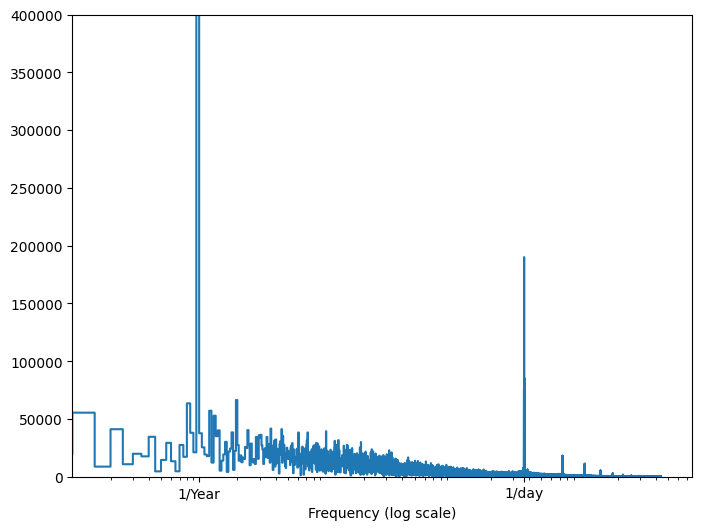

In [5]:
#Which frequencies are important?

fft = tf.signal.rfft(df['Õhutemperatuur °C'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Õhutemperatuur °C'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [6]:
# Split the data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

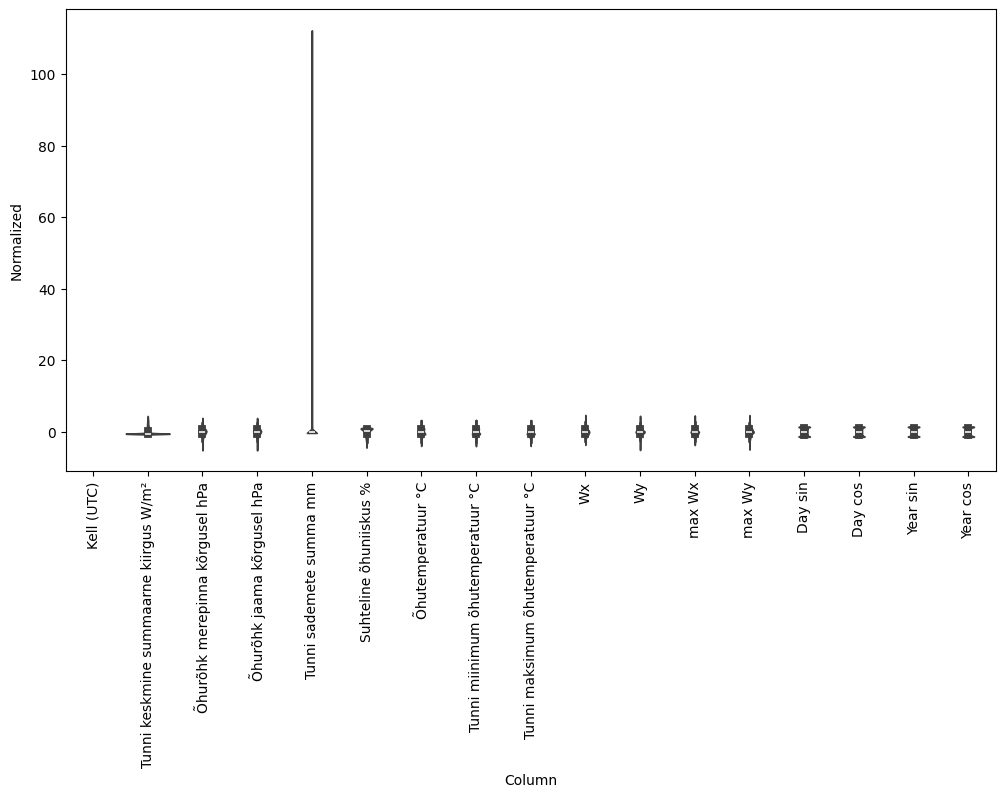

In [7]:
train_df = train_df.apply(pd.to_numeric, errors='coerce')
val_df = val_df.apply(pd.to_numeric, errors='coerce')
test_df = test_df.apply(pd.to_numeric, errors='coerce')
df = df.apply(pd.to_numeric, errors='coerce')

# train_df = train_df.dropna()
# val_df = val_df.dropna()
# test_df = test_df.dropna()
# df = df.dropna()

# Normalize the data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
ax.set_xticks(np.arange(len(df.keys())))
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [8]:
#Data windowing
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [9]:
# Plot the data
plot_cols = ['Tunni keskmine summaarne kiirgus W/m²', 'Õhurõhk merepinna kõrgusel hPa', 'Õhurõhk jaama kõrgusel hPa', 'Tunni sademete summa mm', 'Suhteline õhuniiskus %', 'Õhutemperatuur °C', 'Tunni miinimum õhutemperatuur °C', 'Tunni maksimum õhutemperatuur °C', '10 minuti keskmine tuule suund °', '10 minuti keskmine tuule kiirus m/s', 'Tunni maksimum tuule kiirus m/s']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

KeyError: "['10 minuti keskmine tuule suund °', '10 minuti keskmine tuule kiirus m/s', 'Tunni maksimum tuule kiirus m/s'] not in index"